- first 3 pop uncorrelated x
- spatially 4-6 correlated x
- 7-9 temporally correlated x
- colorcode mean fr x
- calculate mean rf only on strongest connection x
- label HH heatmap x
- only positive time shifts x
- sort hiddens just like visible populations x
- take moments of temporally connected neurons and compare to rbm x
- maybe: put populations in zebrafish brain space

In [2]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

sys.path.append(r'C:\Users\CP\OneDrive\RU\Intern\rtrbm_master')

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

In [3]:
%matplotlib inline

### loading the data

In [4]:
n_neurons = 90
t_max = 30000
n_populations = 9
permute = True
time_shifts = [0, 0, 0, 0, 0, 0, 1, 2, 3]
neuron_population_correlation = [0, .8, .8, .8, .8, .8, .8, .8, .8]
population_correlations = [0, .6, .6, .6, .6, .6, .9, .9, .9]
mean_firing_rate = 0.1

n_neurons_pop = int(n_neurons / n_populations)

spikes = np.zeros((n_neurons, t_max))

# population 1 - 3: uncorrelated
spikes[:n_neurons_pop * 3, :] = np.random.poisson(lam=mean_firing_rate, size=(n_neurons_pop * 3, t_max))

# population 4 - 6: correlated
poisson_grandmother_train1 = np.random.poisson(lam=mean_firing_rate, size=(1, t_max))
poisson_grandmother_train2 = np.random.poisson(lam=mean_firing_rate, size=(1, t_max))

poisson_mother_trains = np.zeros((n_populations, t_max))
for i in range(3, 9):

    delete_spikes = population_correlations[i] * np.ones((1, t_max)) <= np.random.uniform(0, 1, size=(1, t_max))
    noise = np.random.poisson((1 - population_correlations[i]) * mean_firing_rate, (1, t_max))
    if i <= 5:
        poisson_mother_trains[i] = poisson_grandmother_train1 - (delete_spikes * poisson_grandmother_train1) + noise
    else:
        poisson_mother_trains[i] = poisson_grandmother_train2 - (delete_spikes * poisson_grandmother_train2) + noise
    poisson_mother_trains[i] = np.roll(poisson_mother_trains[i], time_shifts[i])  # add time shifts

    # neuron dynamics
    delete_spikes = neuron_population_correlation[i] * np.ones((n_neurons_pop, t_max)) <= \
                    np.random.uniform(0, 1, size=(n_neurons_pop, t_max))
    noise = np.random.poisson((1 - neuron_population_correlation[i]) * mean_firing_rate, (n_neurons_pop, t_max))
    population_spikes = np.tile(poisson_mother_trains[i], (n_neurons_pop, 1))
    population_spikes = population_spikes - (delete_spikes * population_spikes) + noise

    idx = np.arange(n_neurons_pop) + i * n_neurons_pop
    spikes[idx, :] = population_spikes

# make binary
spikes[spikes < 0] = 0
spikes[spikes > 1] = 1

# create 2 dimensional brain-space locations for all neuron populations
mean_locations_pop = [[-1, 1], [0, 1], [1, 1], [-1, 0], [0, 0], [1, 0], [-1, -1], [0, -1], [1, -1]]
neuron_coordinates = np.zeros((n_neurons, 2))
for i in range(n_populations):
    neuron_coordinates[n_neurons_pop * i:n_neurons_pop * (i + 1), :] = 0.25 * np.random.randn(n_neurons_pop, 2) + \
                                                                       mean_locations_pop[i]

# randomly permute neurons
populations_idx = np.arange(n_neurons, dtype=int)
if permute:
    idx = np.random.permutation(n_neurons)
    neuron_coordinates = neuron_coordinates[idx, :]
    populations_idx = populations_idx[np.argsort(idx)]
    spikes = spikes[idx, :]
populations_idx = populations_idx.reshape(n_populations, n_neurons_pop)

data = torch.tensor(spikes, dtype=torch.float)

In [5]:
train_data, test_data = train_test_split(data)

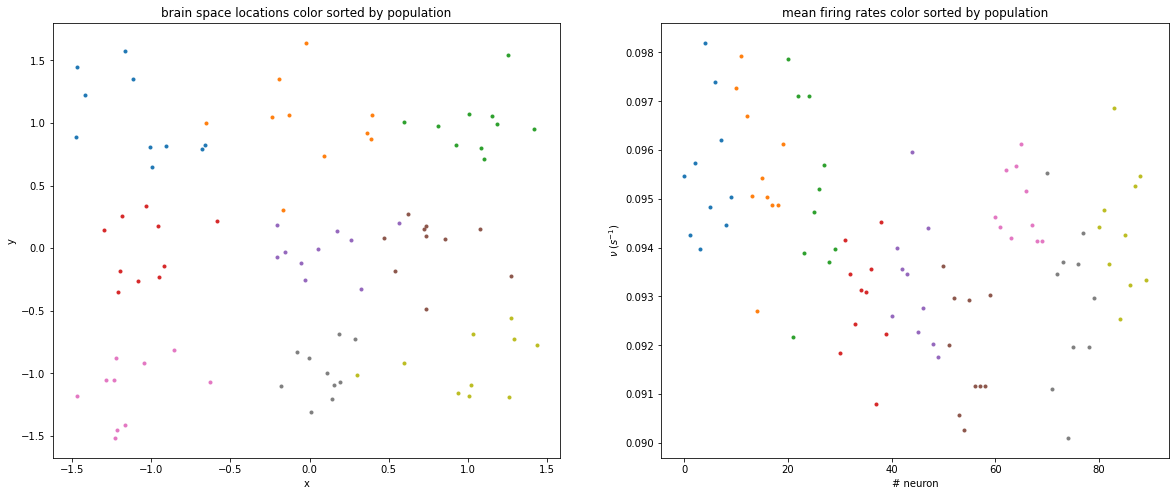

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))


mean_fr = torch.mean(data, 1)
for i in range(9):
    ax[1].plot(np.arange(i*10, (i+1)*10, 1), mean_fr[populations_idx[i, :]], '.')
    ax[0].plot(neuron_coordinates[populations_idx[i, :], 0], neuron_coordinates[populations_idx[i, :], 1], '.')
    
ax[1].set_title('mean firing rates color sorted by population')
ax[1].set_xlabel('# neuron')
ax[1].set_ylabel(r'$\nu \; (s^{-1})$')
ax[0].set_title('brain space locations color sorted by population')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

plt.show()

Text(114.0, 0.5, '# neuron')

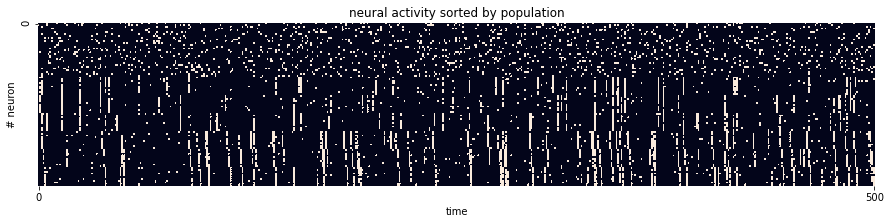

In [7]:
plt.figure(figsize=(15,3))

data_sorted = data[populations_idx.flatten(), :]

ax = sns.heatmap(data[populations_idx.flatten(), :501], cbar=False, xticklabels=500, yticklabels=100)

ax.set_title('neural activity sorted by population')

ax.set_xlabel('time')
ax.set_ylabel('# neuron')

Training the RTRBM

In [8]:
rtrbm = RTRBM(data, N_H=8, device='cpu')
rtrbm.learn(n_epochs=500, batchsize=10, CDk=5, PCD=False, lr=5e-4, lr_end=5e-5, start_decay=200, mom=0, wc=0, sp=3e-4, x=2)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [51:27<00:00,  6.18s/it]


In [38]:
rtrbm.learn(n_epochs=100, batchsize=10, CDk=5, PCD=False, lr=1e-4, mom=0, wc=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:33<00:00,  5.13s/it]


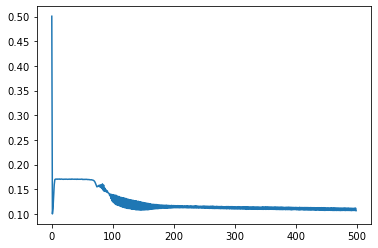

In [11]:
plt.plot(rtrbm.errors)

In [50]:
rtrbm.W


tensor([[ 9.2972e-02, -1.3604e+00,  1.0535e-01, -1.1419e+00,  7.9635e-01,
          8.1920e-01,  7.1354e-02,  1.1322e-01, -3.0094e+00, -3.0946e+00,
         -3.0618e+00,  8.7449e-01,  9.5818e-01,  2.3264e-01,  3.6138e-01,
          2.3316e-01, -1.1280e+00, -2.9602e+00,  1.8620e-01, -8.6559e-02,
          2.6112e-03, -1.1672e-01, -1.6323e-01, -1.1231e+00, -1.1161e+00,
         -1.1341e+00,  9.1329e-02,  9.7985e-01, -8.4598e-01, -1.1670e+00,
         -1.3572e+00,  1.9346e-01, -1.1684e+00,  1.0131e-01,  1.3740e-01,
         -1.0960e+00,  1.1679e-01,  9.2525e-01, -1.4426e+00, -1.2354e+00,
          1.7138e-01, -3.0016e+00,  2.3889e-01, -1.0569e+00,  1.4782e-02,
          7.4668e-02, -5.5951e-03, -1.5439e+00,  2.9140e-02, -4.9612e-02,
          2.2096e-01,  9.2141e-01,  9.3895e-01,  4.6944e-02,  8.2161e-02,
         -1.0802e-01,  2.1742e-02, -1.0021e+00, -2.9340e+00, -1.0395e+00,
         -3.1769e+00,  8.8650e-01, -2.1436e-01,  7.0862e-03,  3.1045e-01,
         -9.8225e-02, -5.2975e-02,  2.

<AxesSubplot:>

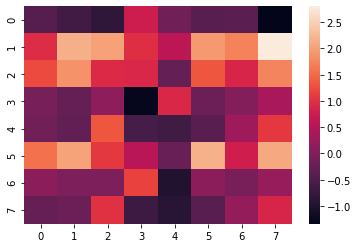

In [56]:
sns.heatmap(rtrbm.W_acc)

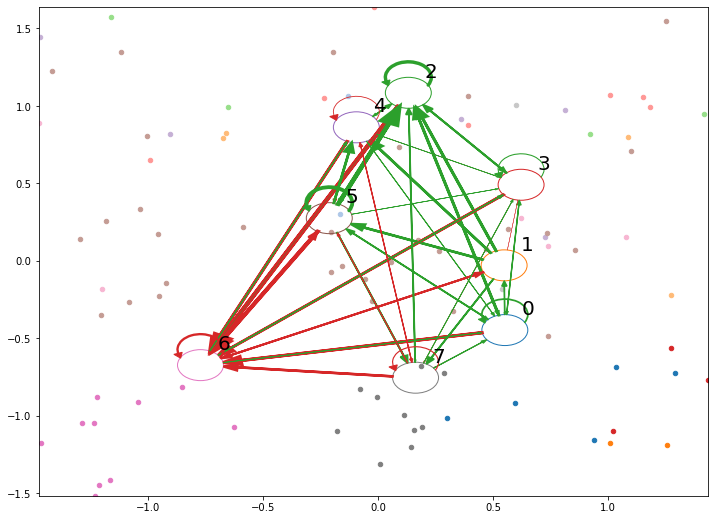

In [12]:
rf = get_hidden_mean_receptive_fields((rtrbm.W), torch.tensor(neuron_coordinates), only_max_conn=True)

create_plot(rtrbm.W, rtrbm.W_acc.T, rf, 
            torch.tensor(neuron_coordinates), 0, dx=0, markersize_visibles=20, 
            hiddens_radius=.1, weight_line_factor=0.3, hidden_weight_thresh=0)

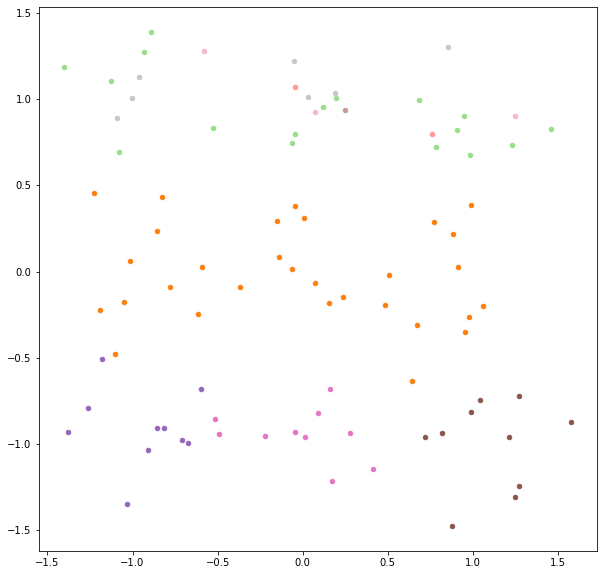

In [40]:
plt.figure(figsize=(10,10))
plot_VH_connections(plt.gca(), rtrbm.W, torch.tensor(neuron_coordinates), markersize=20)

<ipython-input-31-39875ac34fd3>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float)
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]<ipython-input-31-39875ac34fd3>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_train_config = torch.tensor(data[:, torch.randint(0, data.shape[1], (1,))], dtype=torch.float)
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.05it/s]


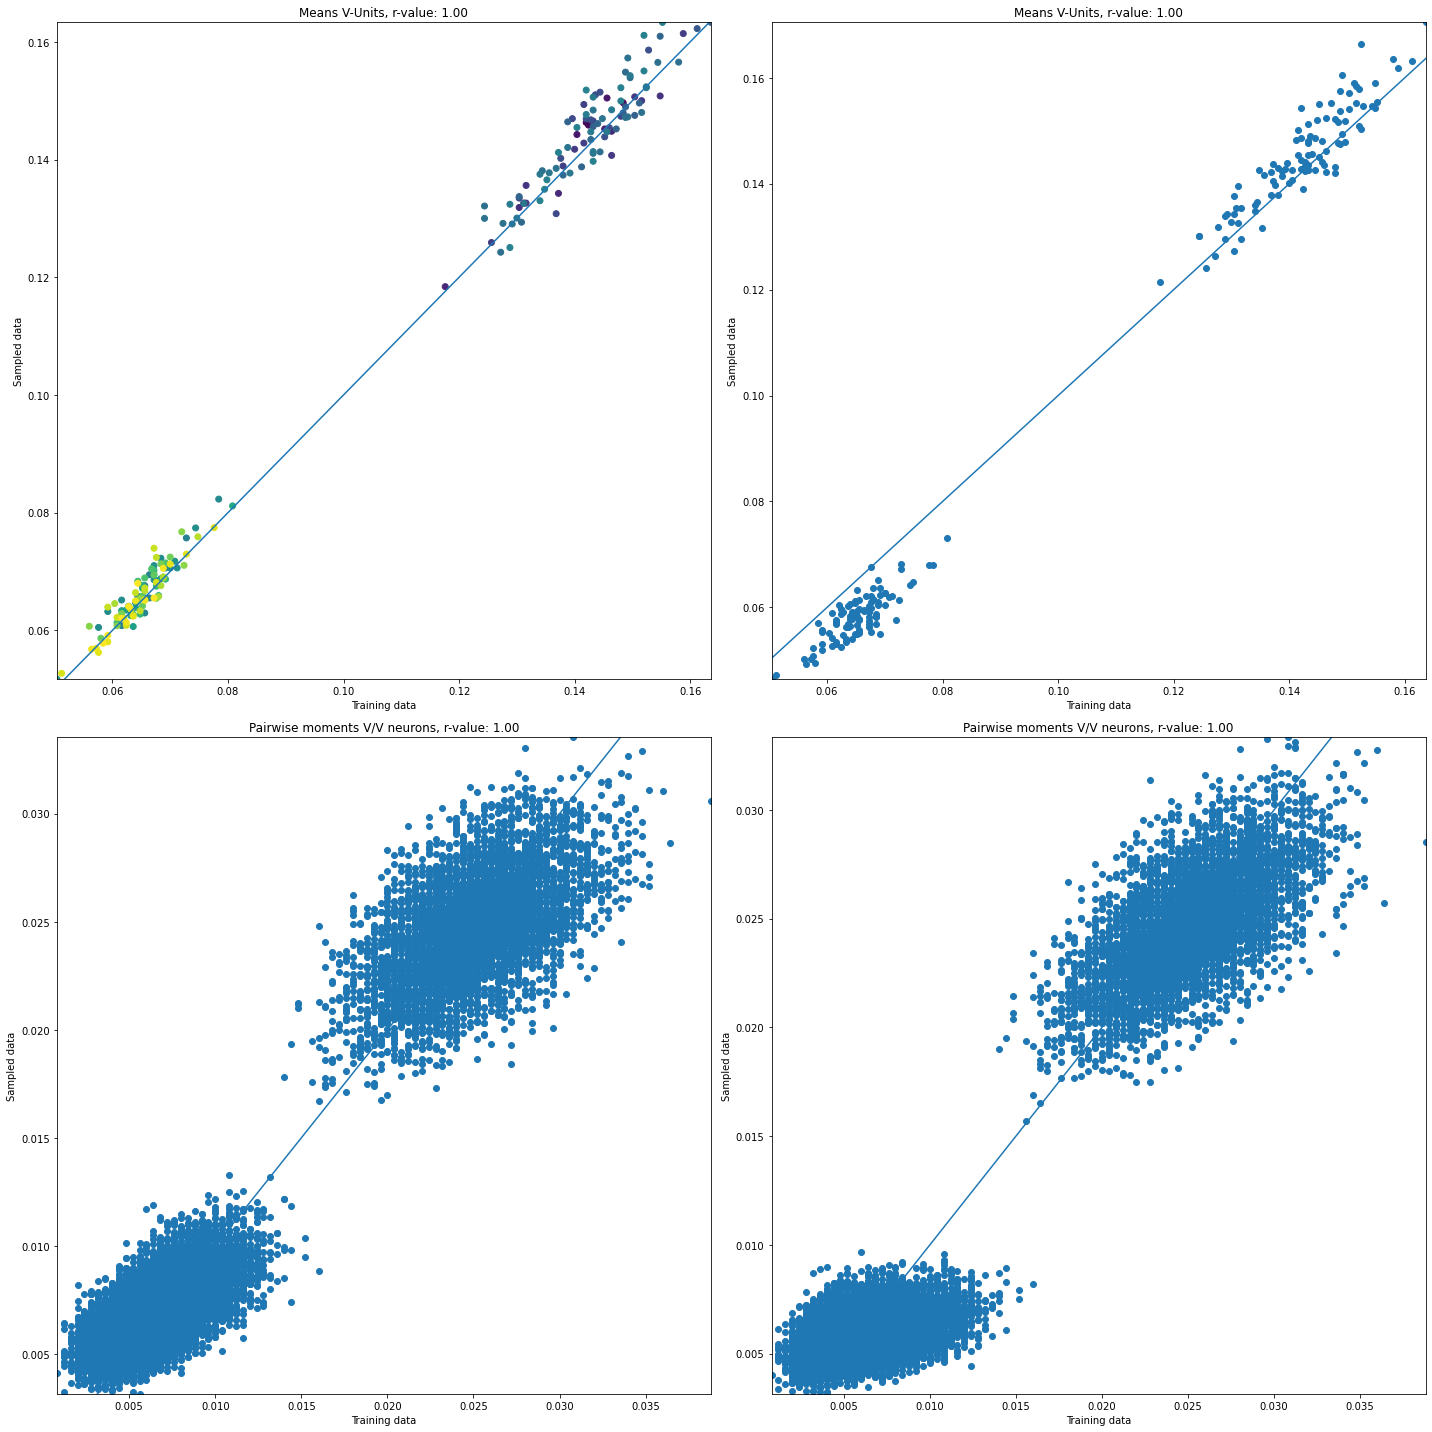

In [31]:
# parameters
chain = 20
pre_gibbs_k = 0
gibbs_k = 1
MC_chains = 1000

data = torch.tensor(data, dtype=torch.float)


for MC_chain in tqdm(range(MC_chains)):
    
    # take a random training configuration
    random_train_config = torch.tensor(data[:, torch.randint(0, data.shape[1], (1,))], dtype=torch.float)
    vs_rbm, hs_rbm = rbm.sample(random_train_config.T, chain=chain, pre_gibbs_k=pre_gibbs_k,
                                          gibbs_k=gibbs_k, mode=1, disable_tqdm=True)
    vs_rtrbm, hs_rtrbm = rtrbm.sample(random_train_config.T.to('cuda'), chain=chain, pre_gibbs_k=pre_gibbs_k,
                                          gibbs_k=gibbs_k, mode=1, disable_tqdm=True)
    
    # catenate all samples
    if MC_chain == 0:
        v_rtrbm = vs_rtrbm.detach().cpu()
        h_rtrbm = hs_rtrbm.detach().cpu()
        
        v_rbm = vs_rbm.detach()
        h_rbm = hs_rbm.detach()
    else:
        v_rtrbm = torch.cat((v_rtrbm, vs_rtrbm.cpu()), 1)
        h_rtrbm = torch.cat((h_rtrbm, hs_rtrbm.cpu()), 1)
        
        v_rbm = torch.cat((v_rbm, vs_rbm), 1)
        h_rbm = torch.cat((h_rbm, hs_rbm), 1)

    
# visibles to hiddens
_, H_data_rbm = rbm.visible_to_hidden(data.T)
H_data_rbm = H_data_rbm.T

H_data_rtrbm = rtrbm.visible_to_expected_hidden(data.to('cuda'), AF=torch.sigmoid)


data_sorted = data[populations_idx.flatten(), :]
v_rbm_sorted = v_rbm[populations_idx.flatten(), :]
v_rtrbm_sorted = v_rtrbm[populations_idx.flatten(), :]

# calculate RBM moments of populatin 7-9 (SO to Luuk)
means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
    moments(data_sorted[600:, :], H_data_rbm, v_rbm_sorted[600:, :], h_rbm)

# create figure
fig, axes = plt.subplots(2, 2, figsize=(20,20))

# mean visible activations rbm
ax = axes[0, 0]
xy = np.vstack([means_V_data, means_V_samples])  # Calculate the point density
z = gaussian_kde(xy)(xy)
idx = z.argsort()
ax.scatter(means_V_data, means_V_samples, c=z[idx])
ax.plot([0, 1], [0, 1])
ax.set_xlim(torch.min(means_V_data), torch.max(means_V_data))
ax.set_ylim(torch.min(means_V_samples), torch.max(means_V_samples))
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Means V-Units, r-value: {:.2f}".format(r_V))

# pariwise mean visible activation rbm
ax = axes[1, 0]
ax.scatter(pw_VV_data, pw_VV_samples)
ax.set_xlim(torch.min(pw_VV_data), torch.max(pw_VV_data))
ax.set_ylim(torch.min(pw_VV_samples), torch.max(pw_VV_samples))
ax.plot([0, 1], [0, 1])
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Pairwise moments V/V neurons, r-value: {:.2f}".format(r_V))


# RTRBM Moments of population 7-9
means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
    moments(data_sorted[600:, :], H_data_rtrbm.cpu(), v_rtrbm_sorted[600:, :], h_rtrbm)

# mean visible activations rtrbm
ax = axes[0, 1]
ax.scatter(means_V_data, means_V_samples)
ax.set_xlim(torch.min(means_V_data), torch.max(means_V_data))
ax.set_ylim(torch.min(means_V_samples), torch.max(means_V_samples))
ax.plot([0, 1], [0, 1])
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Means V-Units, r-value: {:.2f}".format(r_V))

# pariwise mean visible activation rtrbm
ax = axes[1, 1]
ax.scatter(pw_VV_data, pw_VV_samples)
ax.set_xlim(torch.min(pw_VV_data), torch.max(pw_VV_data))
ax.set_ylim(torch.min(pw_VV_samples), torch.max(pw_VV_samples))
ax.plot([0, 1], [0, 1])
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Pairwise moments V/V neurons, r-value: {:.2f}".format(r_V))


fig.tight_layout()
plt.show()

<AxesSubplot:>

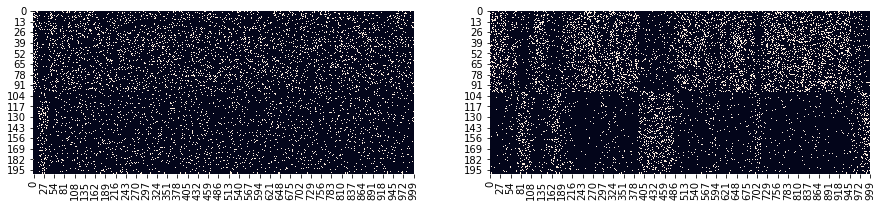

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15,3))
sns.heatmap(v_rtrbm_sorted[600:,:1000], ax=axes[0], cbar=False)
sns.heatmap(v_rbm_sorted[600:,:1000], ax=axes[1], cbar=False)

### time shifted

<AxesSubplot:>

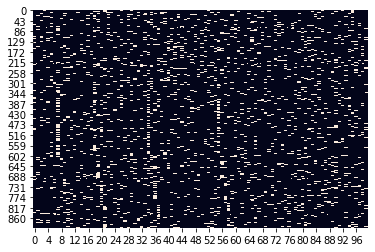

In [39]:
n_neurons = 900
t_max = 2500
n_populations = 9
permute = True
time_shifts = [0, 0, 0, 0, 0, 0, 1, 2, 3]
mean_firing_rate = 0.1

n_neurons_pop = int(n_neurons / n_populations)

spikes = np.zeros((n_neurons, t_max))

# population 1 - 3: uncorrelated
spikes[:n_neurons_pop*3, :] = np.random.poisson(lam=mean_firing_rate, size=(n_neurons_pop*3, t_max))

# population 4 - 6: correlated
corr = .3
poisson_mother_train = np.random.poisson(lam=mean_firing_rate, size=(1, t_max))
# make binary
poisson_mother_train[poisson_mother_train < 0] = 0
poisson_mother_train[poisson_mother_train > 1] = 1

delete_spikes = corr * np.ones((6*n_neurons_pop, t_max)) <= \
                np.random.uniform(0, 1, size=(6*n_neurons_pop, t_max))
noise = np.random.poisson((1 - corr) * mean_firing_rate, (6*n_neurons_pop, t_max))
spikes[3*n_neurons_pop:9*n_neurons_pop, :] = np.tile(poisson_mother_train, (6*n_neurons_pop, 1))
spikes[3*n_neurons_pop:9*n_neurons_pop, :] = spikes[3*n_neurons_pop:9*n_neurons_pop, :] - (delete_spikes * spikes[3*n_neurons_pop:9*n_neurons_pop, :]) + noise

    
# population 6 - 9: time shifted
spikes[6*n_neurons_pop:7*n_neurons_pop, :] = np.roll(spikes[6*n_neurons_pop:7*n_neurons_pop, :], 1)
spikes[7*n_neurons_pop:8*n_neurons_pop, :] = np.roll(spikes[7*n_neurons_pop:8*n_neurons_pop, :], 2)
spikes[8*n_neurons_pop:9*n_neurons_pop, :] = np.roll(spikes[8*n_neurons_pop:9*n_neurons_pop, :], 3)


# make binary
spikes[spikes < 0] = 0
spikes[spikes > 1] = 1

# create 2 dimensional brain-space locations for all neuron populations
mean_locations_pop = [[-1, 1], [0, 1], [1, 1], [-1, 0], [0, 0], [1, 0], [-1, -1], [0, -1], [1, -1]]
neuron_coordinates = np.zeros((n_neurons, 2))
for i in range(n_populations):
    neuron_coordinates[n_neurons_pop * i:n_neurons_pop * (i + 1), :] = 0.25 * np.random.randn(n_neurons_pop, 2) + \
                                                                       mean_locations_pop[i]


populations_idx = np.arange(n_neurons, dtype=int)
data = torch.tensor(spikes, dtype=torch.float)
sns.heatmap(data[:, :100], cbar=False)

In [56]:
rtrbm = RTRBM(data, N_H=8, device='cuda')
rtrbm.learn(n_epochs=5000, batchsize=1, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [44:33<00:00,  1.87it/s]


In [57]:
rbm = RBM(data, N_H=8, device='cpu')
rbm.learn(n_epochs=5000, batchsize=1, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [3:13:25<00:00,  2.32s/it]


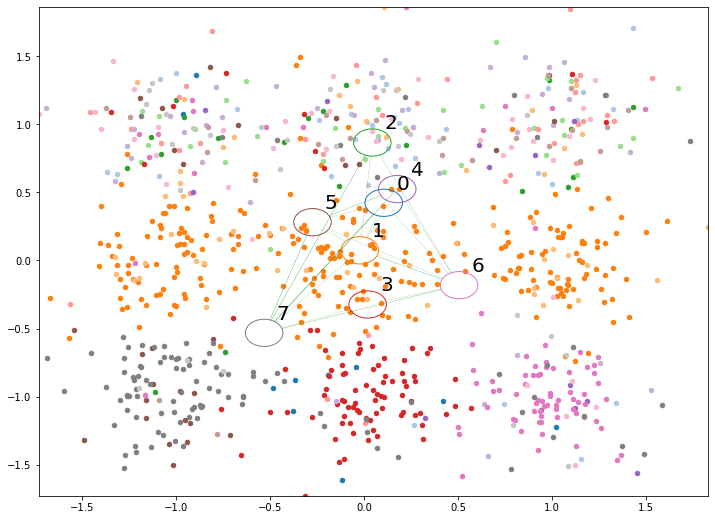

In [58]:
rf = get_hidden_mean_receptive_fields(rtrbm.W.cpu(), torch.tensor(neuron_coordinates), only_max_conn=True)

create_plot(rtrbm.W.cpu(), rtrbm.W_acc.cpu(), rf, 
            torch.tensor(neuron_coordinates), 0, dx=0, markersize_visibles=20, 
            hiddens_radius=.1, weight_line_factor=0, hidden_weight_thresh=1.5)

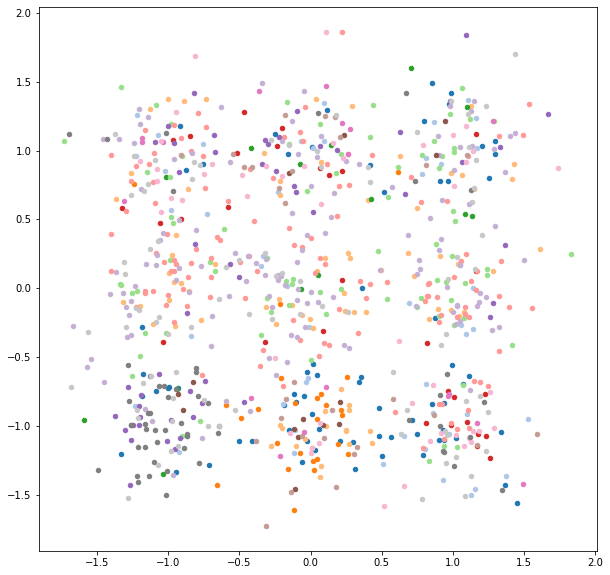

In [59]:
plt.figure(figsize=(10,10))
plot_VH_connections(plt.gca(), rbm.W, torch.tensor(neuron_coordinates), markersize=20)

<ipython-input-60-fa11def2d54b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float)
  0%|                                                                                          | 0/300 [00:00<?, ?it/s]<ipython-input-60-fa11def2d54b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_train_config = torch.tensor(data[:, torch.randint(0, data.shape[1], (1,))], dtype=torch.float)
100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 45.45it/s]


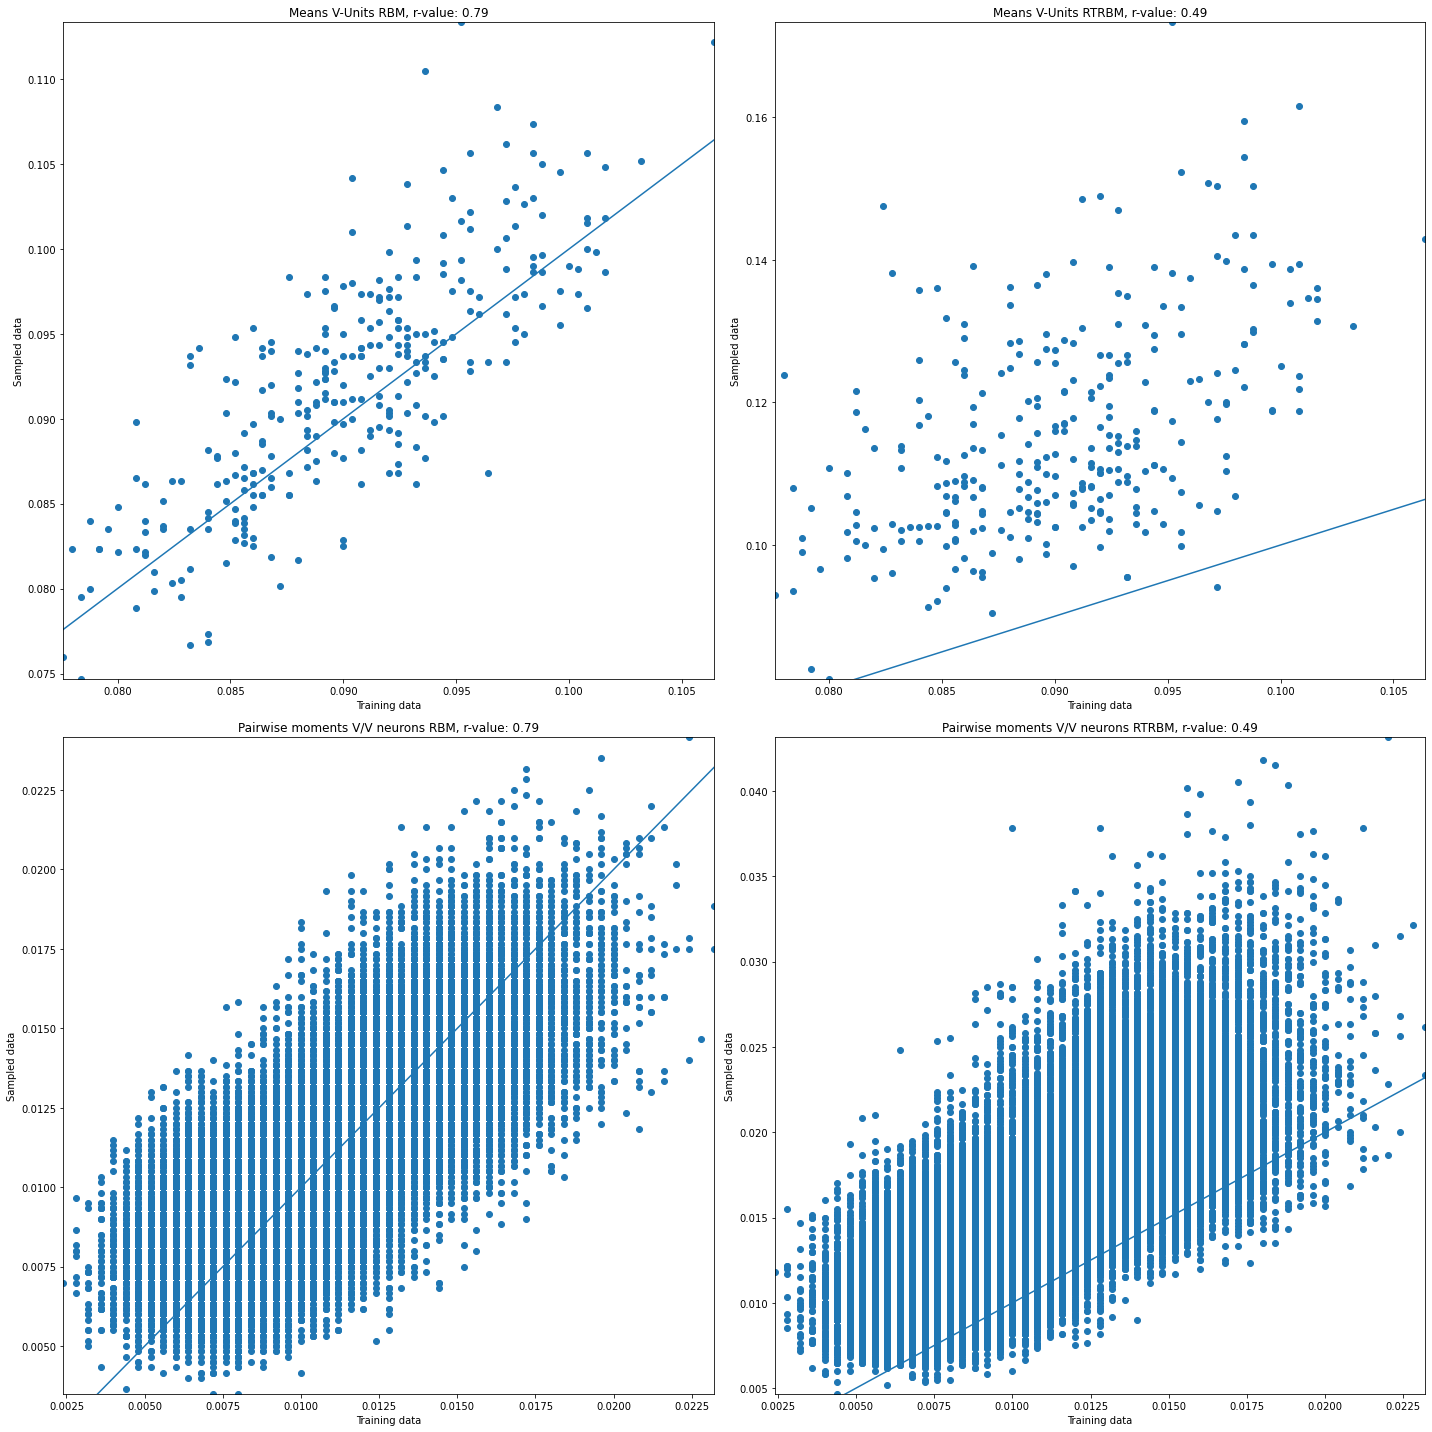

In [60]:
# parameters
chain = 20
pre_gibbs_k = 0
gibbs_k = 1
MC_chains = 300
mode = 1

data = torch.tensor(data, dtype=torch.float)


for MC_chain in tqdm(range(MC_chains)):
    
    # take a random training configuration
    random_train_config = torch.tensor(data[:, torch.randint(0, data.shape[1], (1,))], dtype=torch.float)
    vs_rbm, hs_rbm = rbm.sample(random_train_config.T, chain=chain, pre_gibbs_k=pre_gibbs_k,
                                          gibbs_k=gibbs_k, mode=mode, disable_tqdm=True)
    vs_rtrbm, hs_rtrbm = rtrbm.sample(random_train_config.T.to('cuda'), chain=chain, pre_gibbs_k=pre_gibbs_k,
                                          gibbs_k=gibbs_k, mode=mode, disable_tqdm=True)
    
    # catenate all samples
    if MC_chain == 0:
        v_rtrbm = vs_rtrbm.detach().cpu()
        h_rtrbm = hs_rtrbm.detach().cpu()
        
        v_rbm = vs_rbm.detach()
        h_rbm = hs_rbm.detach()
    else:
        v_rtrbm = torch.cat((v_rtrbm, vs_rtrbm.cpu()), 1)
        h_rtrbm = torch.cat((h_rtrbm, hs_rtrbm.cpu()), 1)
        
        v_rbm = torch.cat((v_rbm, vs_rbm), 1)
        h_rbm = torch.cat((h_rbm, hs_rbm), 1)

    
# visibles to hiddens
_, H_data_rbm = rbm.visible_to_hidden(data.T)
H_data_rbm = H_data_rbm.T

H_data_rtrbm = rtrbm.visible_to_expected_hidden(data.to('cuda'), AF=torch.sigmoid)


data_sorted = data[populations_idx.flatten(), :]
v_rbm_sorted = v_rbm[populations_idx.flatten(), :]
v_rtrbm_sorted = v_rtrbm[populations_idx.flatten(), :]

# calculate RBM moments of populatin 7-9 (SO to Luuk)
means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
    moments(data_sorted[600:, :], H_data_rbm, v_rbm_sorted[600:, :], h_rbm)

# create figure
fig, axes = plt.subplots(2, 2, figsize=(20,20))

# mean visible activations rbm
ax = axes[0, 0]
ax.scatter(means_V_data, means_V_samples)
ax.plot([0, 1], [0, 1])
ax.set_xlim(torch.min(means_V_data), torch.max(means_V_data))
ax.set_ylim(torch.min(means_V_samples), torch.max(means_V_samples))
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Means V-Units RBM, r-value: {:.2f}".format(r_V))

# pariwise mean visible activation rbm
ax = axes[1, 0]
ax.scatter(pw_VV_data, pw_VV_samples)
ax.set_xlim(torch.min(pw_VV_data), torch.max(pw_VV_data))
ax.set_ylim(torch.min(pw_VV_samples), torch.max(pw_VV_samples))
ax.plot([0, 1], [0, 1])
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Pairwise moments V/V neurons RBM, r-value: {:.2f}".format(r_V))


# RTRBM Moments of population 7-9
means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
    moments(data_sorted[600:, :], H_data_rtrbm.cpu(), v_rtrbm_sorted[600:, :], h_rtrbm)

# mean visible activations rtrbm
ax = axes[0, 1]
ax.scatter(means_V_data, means_V_samples)
ax.set_xlim(torch.min(means_V_data), torch.max(means_V_data))
ax.set_ylim(torch.min(means_V_samples), torch.max(means_V_samples))
ax.plot([0, 1], [0, 1])
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Means V-Units RTRBM, r-value: {:.2f}".format(r_V))

# pariwise mean visible activation rtrbm
ax = axes[1, 1]
ax.scatter(pw_VV_data, pw_VV_samples)
ax.set_xlim(torch.min(pw_VV_data), torch.max(pw_VV_data))
ax.set_ylim(torch.min(pw_VV_samples), torch.max(pw_VV_samples))
ax.plot([0, 1], [0, 1])
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Pairwise moments V/V neurons RTRBM, r-value: {:.2f}".format(r_V))


fig.tight_layout()
plt.show()

<AxesSubplot:>

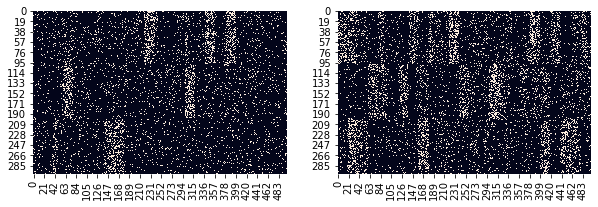

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.heatmap(v_rbm[600:,:500], ax=axes[0], cbar=False)
sns.heatmap(v_rtrbm[600:, :500], ax=axes[1], cbar=False)


### Same activity, only time shifted

<AxesSubplot:>

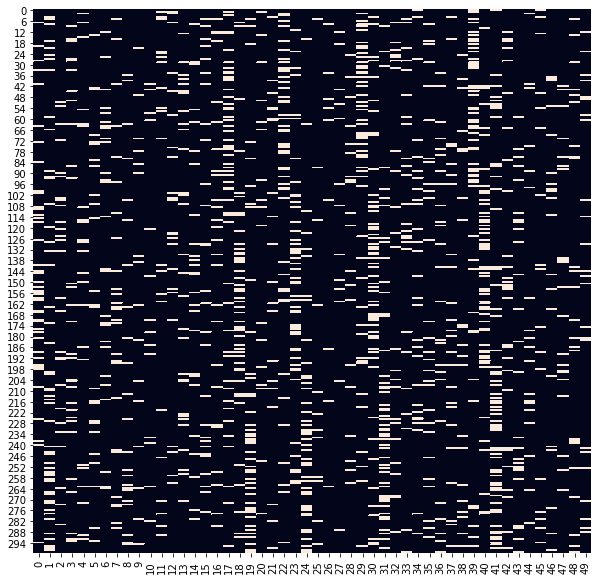

In [78]:
n_neurons = 900
t_max = 2500
n_populations = 9
permute = True
time_shifts = [0, 0, 0, 0, 0, 0, 1, 2, 3]
mean_firing_rate = 0.1

n_neurons_pop = int(n_neurons / n_populations)

spikes = np.zeros((n_neurons, t_max))

# population 1 - 3: uncorrelated
spikes[:n_neurons_pop*3, :] = np.random.poisson(lam=mean_firing_rate, size=(n_neurons_pop*3, t_max))

# population 4 - 6: correlated
corr = .3
poisson_mother_train = np.random.poisson(lam=mean_firing_rate, size=(1, t_max))
# make binary
poisson_mother_train[poisson_mother_train < 0] = 0
poisson_mother_train[poisson_mother_train > 1] = 1

delete_spikes = corr * np.ones((6*n_neurons_pop, t_max)) <= \
                np.random.uniform(0, 1, size=(6*n_neurons_pop, t_max))
noise = np.random.poisson((1 - corr) * mean_firing_rate, (6*n_neurons_pop, t_max))
spikes[3*n_neurons_pop:9*n_neurons_pop, :] = np.tile(poisson_mother_train, (6*n_neurons_pop, 1))
spikes[3*n_neurons_pop:9*n_neurons_pop, :] = spikes[3*n_neurons_pop:9*n_neurons_pop, :] - (delete_spikes * spikes[3*n_neurons_pop:9*n_neurons_pop, :]) + noise

    
# population 6 - 9: time shifted
spikes[7*n_neurons_pop:8*n_neurons_pop, :] = np.roll(spikes[6*n_neurons_pop:7*n_neurons_pop, :], 1)
spikes[8*n_neurons_pop:9*n_neurons_pop, :] = np.roll(spikes[6*n_neurons_pop:7*n_neurons_pop, :], 2)


# make binary
spikes[spikes < 0] = 0
spikes[spikes > 1] = 1

# create 2 dimensional brain-space locations for all neuron populations
mean_locations_pop = [[-1, 1], [0, 1], [1, 1], [-1, 0], [0, 0], [1, 0], [-1, -1], [0, -1], [1, -1]]
neuron_coordinates = np.zeros((n_neurons, 2))
for i in range(n_populations):
    neuron_coordinates[n_neurons_pop * i:n_neurons_pop * (i + 1), :] = 0.25 * np.random.randn(n_neurons_pop, 2) + \
                                                                       mean_locations_pop[i]


populations_idx = np.arange(n_neurons, dtype=int)
data = torch.tensor(spikes, dtype=torch.float)
plt.figure(figsize=(10,10))
sns.heatmap(data[600:, :50], cbar=False)

In [79]:
rtrbm = RTRBM(data, N_H=8, device='cuda')
rtrbm.learn(n_epochs=300, batchsize=1, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:45<00:00,  1.81it/s]


In [80]:
rbm = RBM(data, N_H=8, device='cpu')
rbm.learn(n_epochs=300, batchsize=1, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [12:01<00:00,  2.41s/it]


<ipython-input-83-fa11def2d54b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float)
  0%|                                                                                          | 0/300 [00:00<?, ?it/s]<ipython-input-83-fa11def2d54b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_train_config = torch.tensor(data[:, torch.randint(0, data.shape[1], (1,))], dtype=torch.float)
100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 44.28it/s]


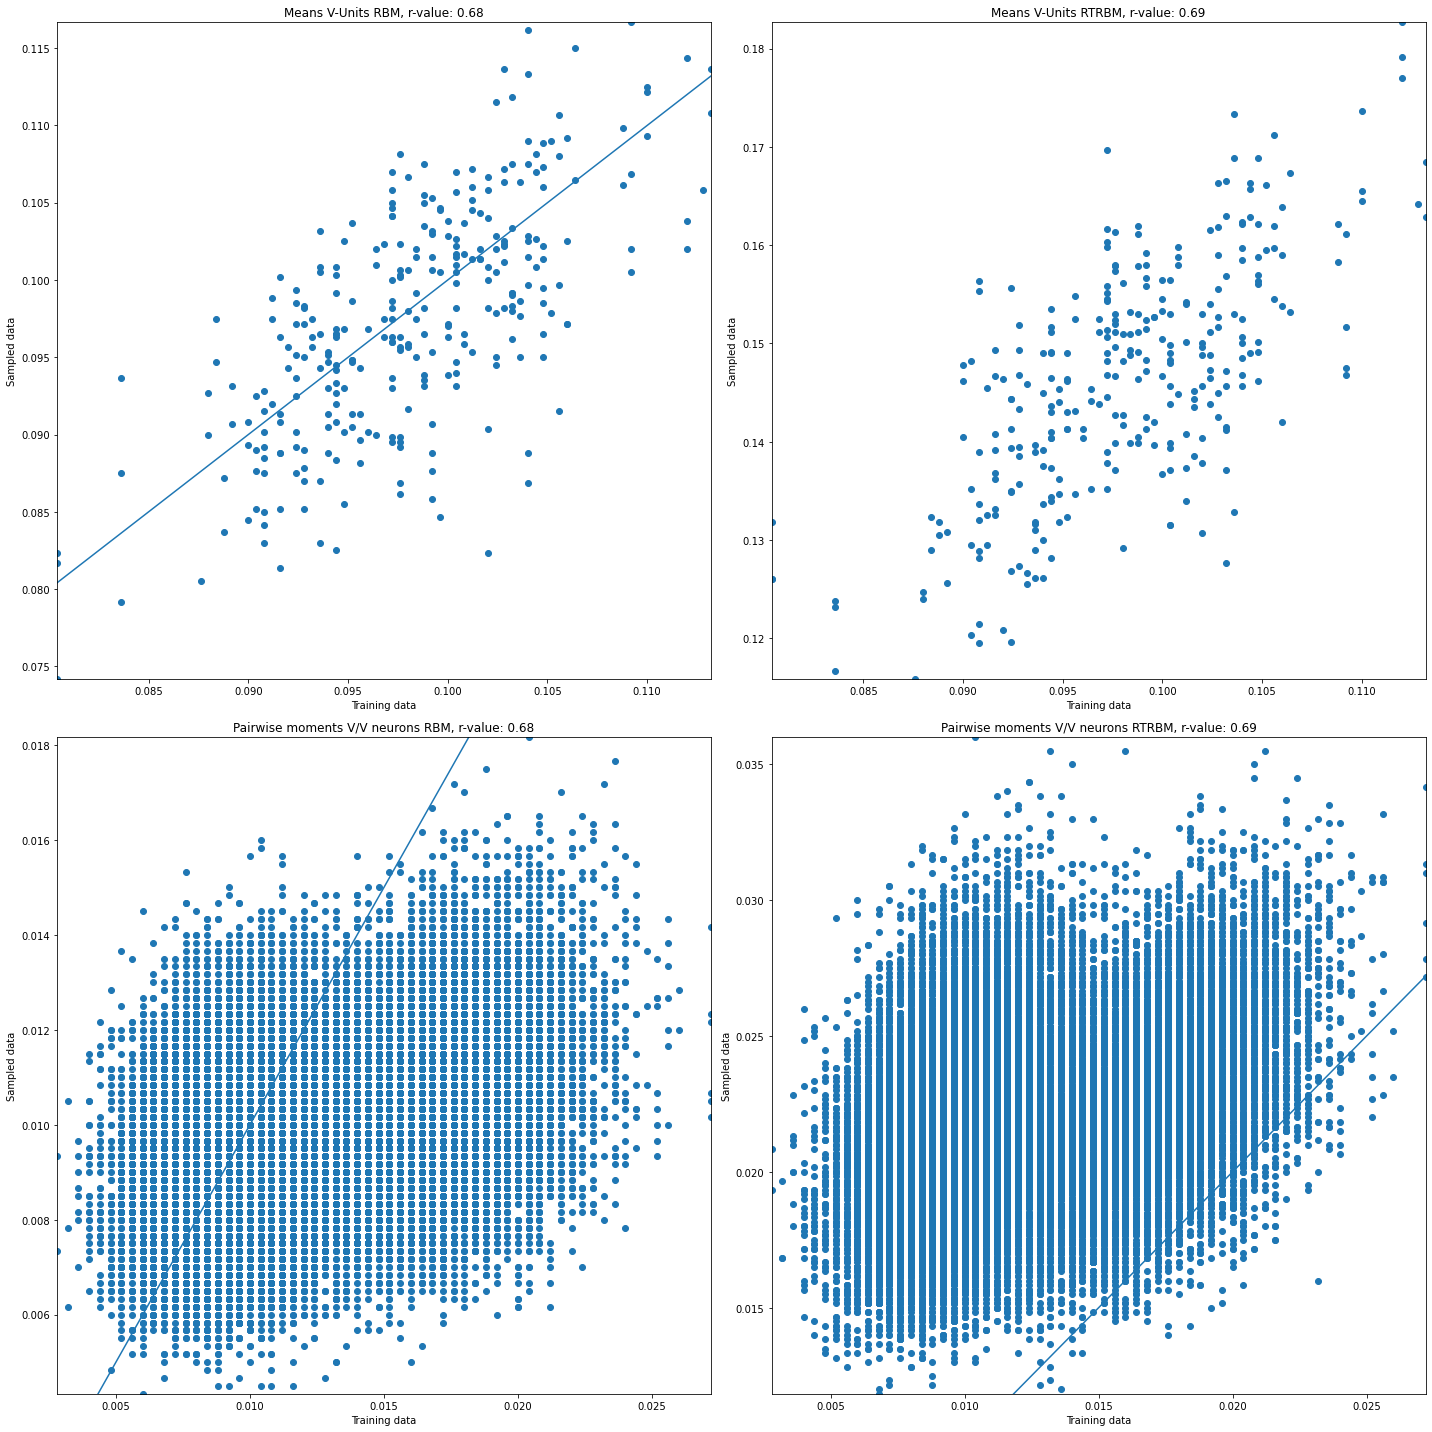

In [83]:
# parameters
chain = 20
pre_gibbs_k = 0
gibbs_k = 1
MC_chains = 300
mode = 1

data = torch.tensor(data, dtype=torch.float)


for MC_chain in tqdm(range(MC_chains)):
    
    # take a random training configuration
    random_train_config = torch.tensor(data[:, torch.randint(0, data.shape[1], (1,))], dtype=torch.float)
    vs_rbm, hs_rbm = rbm.sample(random_train_config.T, chain=chain, pre_gibbs_k=pre_gibbs_k,
                                          gibbs_k=gibbs_k, mode=mode, disable_tqdm=True)
    vs_rtrbm, hs_rtrbm = rtrbm.sample(random_train_config.T.to('cuda'), chain=chain, pre_gibbs_k=pre_gibbs_k,
                                          gibbs_k=gibbs_k, mode=mode, disable_tqdm=True)
    
    # catenate all samples
    if MC_chain == 0:
        v_rtrbm = vs_rtrbm.detach().cpu()
        h_rtrbm = hs_rtrbm.detach().cpu()
        
        v_rbm = vs_rbm.detach()
        h_rbm = hs_rbm.detach()
    else:
        v_rtrbm = torch.cat((v_rtrbm, vs_rtrbm.cpu()), 1)
        h_rtrbm = torch.cat((h_rtrbm, hs_rtrbm.cpu()), 1)
        
        v_rbm = torch.cat((v_rbm, vs_rbm), 1)
        h_rbm = torch.cat((h_rbm, hs_rbm), 1)

    
# visibles to hiddens
_, H_data_rbm = rbm.visible_to_hidden(data.T)
H_data_rbm = H_data_rbm.T

H_data_rtrbm = rtrbm.visible_to_expected_hidden(data.to('cuda'), AF=torch.sigmoid)


data_sorted = data[populations_idx.flatten(), :]
v_rbm_sorted = v_rbm[populations_idx.flatten(), :]
v_rtrbm_sorted = v_rtrbm[populations_idx.flatten(), :]

# calculate RBM moments of populatin 7-9 (SO to Luuk)
means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
    moments(data_sorted[600:, :], H_data_rbm, v_rbm_sorted[600:, :], h_rbm)

# create figure
fig, axes = plt.subplots(2, 2, figsize=(20,20))

# mean visible activations rbm
ax = axes[0, 0]
ax.scatter(means_V_data, means_V_samples)
ax.plot([0, 1], [0, 1])
ax.set_xlim(torch.min(means_V_data), torch.max(means_V_data))
ax.set_ylim(torch.min(means_V_samples), torch.max(means_V_samples))
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Means V-Units RBM, r-value: {:.2f}".format(r_V))

# pariwise mean visible activation rbm
ax = axes[1, 0]
ax.scatter(pw_VV_data, pw_VV_samples)
ax.set_xlim(torch.min(pw_VV_data), torch.max(pw_VV_data))
ax.set_ylim(torch.min(pw_VV_samples), torch.max(pw_VV_samples))
ax.plot([0, 1], [0, 1])
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Pairwise moments V/V neurons RBM, r-value: {:.2f}".format(r_V))


# RTRBM Moments of population 7-9
means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
    moments(data_sorted[600:, :], H_data_rtrbm.cpu(), v_rtrbm_sorted[600:, :], h_rtrbm)

# mean visible activations rtrbm
ax = axes[0, 1]
ax.scatter(means_V_data, means_V_samples)
ax.set_xlim(torch.min(means_V_data), torch.max(means_V_data))
ax.set_ylim(torch.min(means_V_samples), torch.max(means_V_samples))
ax.plot([0, 1], [0, 1])
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Means V-Units RTRBM, r-value: {:.2f}".format(r_V))

# pariwise mean visible activation rtrbm
ax = axes[1, 1]
ax.scatter(pw_VV_data, pw_VV_samples)
ax.set_xlim(torch.min(pw_VV_data), torch.max(pw_VV_data))
ax.set_ylim(torch.min(pw_VV_samples), torch.max(pw_VV_samples))
ax.plot([0, 1], [0, 1])
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Pairwise moments V/V neurons RTRBM, r-value: {:.2f}".format(r_V))


fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'RTRBM')

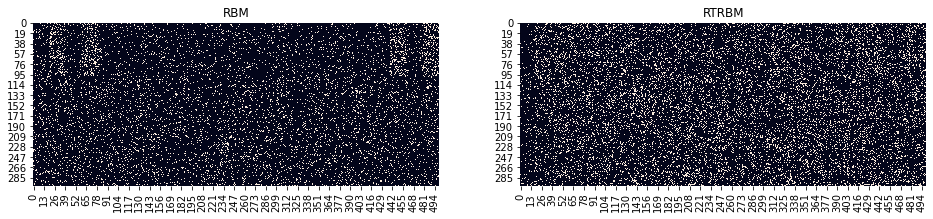

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
sns.heatmap(v_rbm[600:,:500], ax=axes[0], cbar=False)
axes[0].set_title('RBM')
sns.heatmap(v_rtrbm[600:, :500], ax=axes[1], cbar=False)
axes[1].set_title('RTRBM')
